In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyBboxPatch
from matplotlib.offsetbox import AnnotationBbox
import seaborn as sns
import textwrap
import skunk
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import selfies as sf
import exmol
from dataclasses import dataclass
from rdkit.Chem.Draw import rdDepictor, MolsToGridImage
from rdkit.Chem import MolFromSmiles, MACCSkeys

rdDepictor.SetPreferCoordGen(True)
sns.set_context("notebook")
sns.set_style(
    "dark",
    {
        "xtick.bottom": True,
        "ytick.left": True,
        "xtick.color": "#666666",
        "ytick.color": "#666666",
        "axes.edgecolor": "#666666",
        "axes.linewidth": 0.8,
        "figure.dpi": 300,
    },
)
color_cycle = ["#F06060", "#1BBC9B", "#F06060", "#5C4B51", "#F3B562", "#6e5687"]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=color_cycle)
mpl.rcParams["font.size"] = 12
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv"
)
features_start_at = list(soldata.columns).index("MolWt")
np.random.seed(0)

In [ ]:
# scramble them
soldata = soldata.sample(frac=0.01, random_state=1).reset_index(drop=True)
soldata.head()

In [ ]:
selfies_list = []
for s in soldata.SMILES:
    try:
        selfies_list.append(sf.encoder(exmol.sanitize_smiles(s)[1]))
    except sf.EncoderError:
        selfies_list.append(None)
len(selfies_list)

In [ ]:
basic = set(exmol.get_basic_alphabet())
data_vocab = set(
    sf.get_alphabet_from_selfies([s for s in selfies_list if s is not None])
)
vocab = ['[nop]']
vocab.extend(list(data_vocab.union(basic)))
vocab_stoi = {o: i for o, i in zip(vocab, range(len(vocab)))}


def selfies2ints(s):
    result = []
    for token in sf.split_selfies(s):
        if token == '.':
            continue  # ?
        if token in vocab_stoi:
            result.append(vocab_stoi[token])
        else:
            result.append(np.nan)
            # print('Warning')
    return result


def ints2selfies(v):
    return "".join([vocab[i] for i in v])


# test them out
s = selfies_list[0]
print('selfies:', s)
v = selfies2ints(s)
print('selfies2ints:', v)
so = ints2selfies(v)
print('ints2selfes:', so)
assert so == s.replace(
    '.', ''
)  # make sure '.' is removed from Selfies string during assertion

In [ ]:
# creating an object
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    embedding_dim: int
    rnn_units: int
    hidden_dim: int


config = Config(
    vocab_size=len(vocab),
    example_number=len(selfies_list),
    batch_size=16,
    buffer_size=10000,
    embedding_dim=256,
    hidden_dim=128,
    rnn_units=128,
)

In [ ]:
# now get sequences
encoded = [selfies2ints(s) for s in selfies_list if s is not None]
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding="post")

# Now build dataset
data = tf.data.Dataset.from_tensor_slices(
    (padded_seqs, soldata.Solubility.iloc[[bool(s) for s in selfies_list]].values)
)
# now split into val, test, train and batch
N = len(data)
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), nontest.skip(
    split
).shuffle(config.buffer_size).batch(config.batch_size).prefetch(
    tf.data.experimental.AUTOTUNE
)

In [ ]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated as padding mask
model.add(
    tf.keras.layers.Embedding(
        input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True
    )
)

# RNN layer
model.add(tf.keras.layers.GRU(config.rnn_units))
# a dense hidden layer
model.add(tf.keras.layers.Dense(config.hidden_dim, activation="relu"))
# regression, so no activation
model.add(tf.keras.layers.Dense(1))

model.summary()

In [ ]:
model.compile(tf.optimizers.Adam(1e-4), loss="mean_squared_error")
result = model.fit(train_data, validation_data=val_data, epochs=100, verbose=2)

In [ ]:
model.save("solubility-rnn-accurate")
# model = tf.keras.models.load_model('solubility-rnn-accurate/')

In [ ]:
plt.figure(figsize=(5, 3.5))
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("rnn-loss.png", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
yhat = []
test_y = []
for x, y in test_data:
    yhat.extend(model(x).numpy().flatten())
    test_y.extend(y.numpy().flatten())
yhat = np.array(yhat)
test_y = np.array(test_y)

# plot test data
plt.figure(figsize=(5, 3.5))
plt.plot(test_y, test_y, ":")
plt.plot(test_y, yhat, ".")
plt.text(
    max(test_y) - 6,
    min(test_y) + 1,
    f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}",
)
plt.text(
    max(test_y) - 6, min(test_y), f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}"
)
plt.xlabel(r"$y$")
plt.ylabel(r"$\hat{y}$")
plt.title("Testing Data")
plt.savefig("rnn-fit.png", dpi=300, bbox_inches="tight")
plt.show()

## LIME explanations

In the following example, we find out what descriptors influence solubility of a molecules. For example, let's say we have a molecule with LogS=1.5. We create a perturbed chemical space around that molecule using `stoned` method and then use `lime` to find out which descriptors affect solubility predictions for that molecule. 

### Define functions used for this method

In [ ]:
# Predictor function is used as input to sample_space function
def predictor_function(smile_list, selfies):
    encoded = [selfies2ints(s) for s in selfies]
    # check for nans
    valid = [1.0 if sum(e) > 0 else np.nan for e in encoded]
    encoded = [np.nan_to_num(e, nan=0) for e in encoded]
    padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding="post")
    labels = np.reshape(model.predict(padded_seqs), (-1))
    return labels * valid

In [ ]:
# Gives indices for descriptor names
def feature_dict(space):
    features = {
        a: b
        for a, b in zip(
            space[0].descriptors.descriptor_names,
            np.arange(len(space[0].descriptors.descriptors)),
        )
    }
    return features

## Plot WLS Fit and show which descriptors matter for an instance

In [ ]:
MolFromSmiles(soldata.SMILES[5])

In [ ]:
stoned_kwargs = {
    "num_samples": 2500,
    "alphabet": exmol.get_basic_alphabet(),
    "max_mutations": 1,
}
space = exmol.sample_space(
    soldata.SMILES[5], predictor_function, stoned_kwargs=stoned_kwargs
)
# 3826 is a highly soluble compound

In [ ]:
from mordred import HydrogenBond, Polarizability
from mordred import SLogP, AcidBase, BertzCT, Aromatic, BondCount
from mordred import Calculator
import scipy.stats as ss

%matplotlib inline

desc_type = ["Classic", "MACCS"]

for d in desc_type:
    space_tstats, beta = exmol.lime_explain(space, descriptor_type=d)
    exmol.plot_descriptors(space, space_tstats, d)

plt.show()

In [ ]:
fkw = {"figsize": (6, 4)}
font = {"family": "normal", "weight": "normal", "size": 16}

fig = plt.figure(figsize=(10, 5))
mpl.rc("axes", titlesize=12)
mpl.rc("font", size=16)
ax_dict = fig.subplot_mosaic("AABBB")

# Plot space by fit
svg = exmol.plot_utils.plot_space_by_fit(
    space,
    [space[0]],
    figure_kwargs=fkw,
    mol_size=(200, 200),
    offset=1,
    ax=ax_dict["B"],
    beta=beta,
)
# Compute y_wls
w = np.array([1 / (1 + (1 / (e.similarity + 0.000001) - 1) ** 5) for e in space])
non_zero = w > 10 ** (-6)
w = w[non_zero]
N = nonzero_w.shape[0]

ys = np.array([e.yhat for e in space])[non_zero].reshape(N).astype(float)
ys -= np.mean(ys)
x_mat = np.array([list(e.descriptors.descriptors) for e in space])[non_zero].reshape(
    N, -1
)
y_wls = x_mat @ beta

lower = np.min(ys)
higher = np.max(ys)

# set transparency using w
normalizer = plt.Normalize(min(w), max(w))
cmap = plt.cm.Oranges(w)
cmap[:, -1] = w


def weighted_mean(x, w):
    return np.sum(x * w) / np.sum(w)


def weighted_cov(x, y, w):
    return np.sum(w * (x - weighted_mean(x, w)) * (y - weighted_mean(y, w))) / np.sum(w)


def weighted_correlation(x, y, w):
    return weighted_cov(x, y, w) / np.sqrt(
        weighted_cov(x, x, w) * weighted_cov(y, y, w)
    )


corr = weighted_correlation(ys, y_wls, w)

ax_dict["A"].plot(
    np.linspace(lower, higher, 100), np.linspace(lower, higher, 100), "--", linewidth=2
)
sc = ax_dict["A"].scatter(ys, y_wls, s=50, marker=".", c=cmap, cmap=cmap)
ax_dict["A"].text(max(ys) - 3, min(ys) + 1, f"weighted \ncorrelation = {corr:.3f}")
ax_dict["A"].set_xlabel(r"$\hat{y}$")
ax_dict["A"].set_ylabel(r"$g$")
ax_dict["A"].set_title("Weighted Least Squares Fit")
ax_dict["A"].set_xlim(lower, higher)
ax_dict["A"].set_ylim(lower, higher)
ax_dict["A"].set_aspect(1.0 / ax_dict["A"].get_data_ratio(), adjustable="box")
cbar = plt.colorbar(sc, orientation="horizontal", pad=0.15, ax=ax_dict["A"])
cbar.set_label("Chemical similarity")
plt.tight_layout()
plt.savefig("weighted_fit.svg", dpi=300, bbox_inches="tight", transparent=False)

In [ ]:
plt.cm.Oranges

## Robustness to incomplete sampling

We first sample a reference chemical space, and then subsample smaller chemical spaces from this reference. Rank correlation is computed between important descriptors for the smaller subspaces and the reference space.

#### Get descriptor attributions for the reference space

In [ ]:
# Sample a big space
stoned_kwargs = {
    "num_samples": 5000,
    "alphabet": exmol.get_basic_alphabet(),
    "max_mutations": 2,
}
space = exmol.sample_space(
    soldata.SMILES[10], predictor_function, stoned_kwargs=stoned_kwargs
)
len(space)

In [ ]:
# get descriptor attributions
space_tstats, beta = exmol.lime_explain(space, "MACCS")

In [ ]:
# Get feature ids
features = feature_dict(space)

In [ ]:
# Get reference set of ranks for the above space
baseline_imp = {
    a: b
    for a, b in zip(space[0].descriptors.descriptor_names, space_tstats)
    if not np.isnan(b)
}
baseline_imp = dict(
    sorted(baseline_imp.items(), key=lambda item: abs(item[1]), reverse=True)
)
baseline_set = [features[x] for x in baseline_imp.keys()]
# baseline_ohs = [0 if i not in baseline_set[:5] else 1 for i in range(len(features))]

In [ ]:
# Get subsets and calculate lime importances - subsample - get rank correlation
from scipy.stats import spearmanr

print("Baseline (full space):", baseline_set[:5])  # initially top 20
plt.figure(figsize=(4, 3))
N = len(space)
size = np.arange(500, N, 1000)
rank_corr = {N: 1}
for i, f in enumerate(size):
    # subsample space
    rank_corr[f] = []
    for _ in range(10):
        idx = np.random.choice(np.arange(N), size=f, replace=False)
        subspace = [space[i] for i in idx]
        # get desc attributions
        ss_tstats, ss_beta = exmol.lime_explain(subspace, descriptor_type="MACCS")
        ss_imp = {
            a: b
            for a, b in zip(subspace[0].descriptors.descriptor_names, ss_tstats)
            if not np.isnan(b)
        }
        ss_imp = dict(
            sorted(ss_imp.items(), key=lambda item: abs(item[1]), reverse=True)
        )
        ss_set = [features[x] for x in ss_imp.keys()]
        # Get ranks for baseline and subsampled space
        ranks = {a: [b] for a, b in zip(baseline_set[:5], np.arange(1, 6))}
        for j, s in enumerate(ss_set):
            if s in ranks:
                ranks[s].append(j + 1)
        print(ranks)
        # compute rank correlation
        r = spearmanr(np.arange(1, 6), [ranks[x][1] for x in ranks])
        rank_corr[f].append(r.correlation)

    plt.scatter(f, np.mean(rank_corr[f]), color="#13254a", marker="o")

plt.scatter(N, 1.0, color="red", marker="o")
plt.axvline(x=N, linestyle=":", color="red")
plt.xlabel("Size of chemical space")
plt.ylabel("Rank correlation")
plt.tight_layout()
plt.savefig("rank correlation.svg", dpi=300, bbox_inches="tight")

## Effect of mutation number, alphabet and size of chemical space

In [ ]:
from rdkit.Chem.Draw import MolToFile, MolToSVG

smi = MolFromSmiles(soldata.SMILES[5])
MolToFile(smi, "mol_params.svg")

In [ ]:
# Mutation

smi = soldata.SMILES[5]
# tstats, beta = {'Classic': [], 'MACCS': []}, {'Classic': [], 'MACCS': []}
# spaces = {'Classic':[], 'MACCS': []}
desc_type = ["Classic", "MACCS"]
muts = [1, 2, 3]
for i in muts:
    stoned_kwargs = {
        "num_samples": 2500,
        "alphabet": exmol.get_basic_alphabet(),
        "min_mutations": i,
        "max_mutations": i,
    }
    space = exmol.sample_space(smi, predictor_function, stoned_kwargs=stoned_kwargs)
    for d in desc_type:
        # get sample t-stats
        space_tstats, beta = exmol.lime_explain(space, descriptor_type=d)
        exmol.plot_descriptors(
            space, space_tstats, d, output_file=f"desc_{d}_mut{i}.svg"
        )

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(8, 3), dpi=180, squeeze=True, sharey=True)
smi = soldata.SMILES[5]
for i, n in enumerate([1, 2, 3]):
    stoned_kwargs = {
        "num_samples": 2500,
        "alphabet": exmol.get_basic_alphabet(),
        "min_mutations": n,
        "max_mutations": n,
    }
    space = exmol.sample_space(smi, predictor_function, stoned_kwargs=stoned_kwargs)
    axs[i].hist(
        [e.similarity for e in space[1:]], bins=99, edgecolor="none", label=d, alpha=0.6
    )
    axs[i].set_title(f"Mutations = {n}")
    axs[i].set_xlim(0, 1)
# plt.legend()
plt.tight_layout()
plt.savefig("rnn-mutation-hist.png", bbox_inches="tight", dpi=180)

In [ ]:
# Alphabet

basic = exmol.get_basic_alphabet()
train = sf.get_alphabet_from_selfies(selfies_list)
wide = sf.get_semantic_robust_alphabet()
desc_type = ["Classic", "MACCS"]
alphs = {"Basic": basic, "Training Data": train, "SELFIES": wide}

for a in alphs:
    stoned_kwargs = {"num_samples": 2500, "alphabet": alphs[a], "max_mutations": 2}
    space = exmol.sample_space(smi, predictor_function, stoned_kwargs=stoned_kwargs)
    for d in desc_type:
        # get sample t-stats
        space_tstats, beta = exmol.lime_explain(space, descriptor_type=d)
        exmol.plot_descriptors(
            space, space_tstats, d, output_file=f"desc_{d}_alph_{a}.svg"
        )

In [ ]:
# Size of space

tstats, beta = {"Classic": [], "MACCS": []}, {"Classic": [], "MACCS": []}
spaces = {"Classic": [], "MACCS": []}
desc_type = ["Classic", "MACCS"]
space_size = [1500, 2000, 2500]

for a in space_size:
    stoned_kwargs = {
        "num_samples": a,
        "alphabet": exmol.get_basic_alphabet(),
        "max_mutations": 2,
    }
    space = exmol.sample_space(smi, predictor_function, stoned_kwargs=stoned_kwargs)
    for d in desc_type:
        space_tstats, beta = exmol.lime_explain(space, descriptor_type=d)
        exmol.plot_descriptors(
            space, space_tstats, d, output_file=f"desc_{d}_size_{a}.svg"
        )

### AqSolDB dataset

Compounds can be classified according to solubility values (LogS); Compounds with 0 and higher solubility value are highly soluble, those in the range of 0 to −2 are soluble, those in the range of −2 to −4 are slightly soluble and insoluble if less than −4.

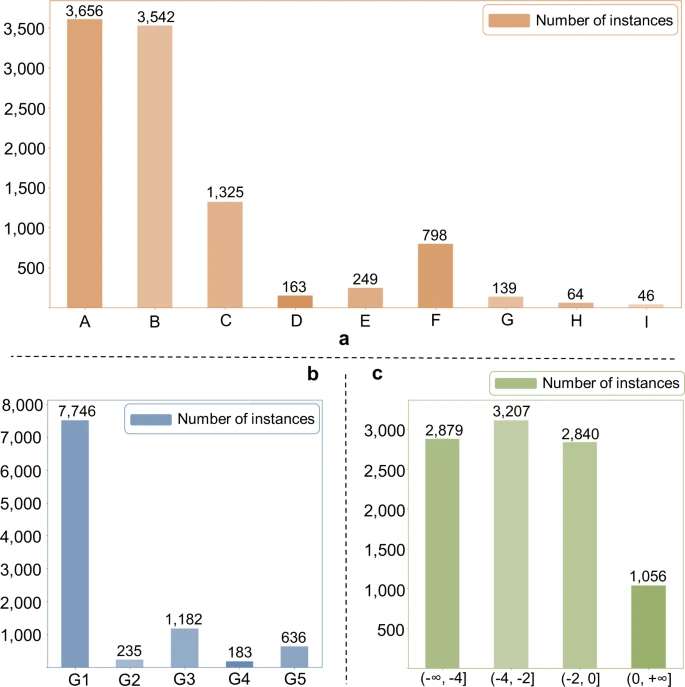